<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/ud_l6_transfer_lng_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
CLASSIFIER_URL="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES=224

model=tf.keras.Sequential([hub.KerasLayer(CLASSIFIER_URL,input_shape=(IMAGE_RES,IMAGE_RES,3))])

In [4]:
import numpy as np
import PIL.Image as Image

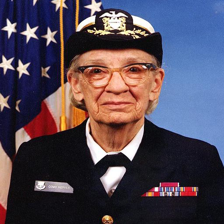

In [5]:
grace_hopper=tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper=Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [6]:
grace_hopper=np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result=model.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

In [8]:
predicted_class=np.argmax(result)
predicted_class

653

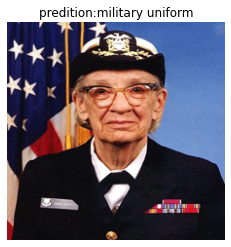

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_classname=imagenet_labels[predicted_class]
_=plt.title('predition:' + predicted_classname)

In [10]:
imagenet_labels[predicted_class]

'military uniform'

# **`Predict the Dogs and cats with pre-trained model`**

In [11]:
(train_examples, validation_examples), info=tfds.load('cats_vs_dogs',split=['train[:80%]','train[80%:]'],with_info=True,as_supervised=True)

In [12]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [13]:
for i,example_image in enumerate(train_examples.take(3)):
  print('Image {} shape: {}'.format(i,example_image[0].shape))

Image 0 shape: (262, 350, 3)
Image 1 shape: (409, 336, 3)
Image 2 shape: (493, 500, 3)


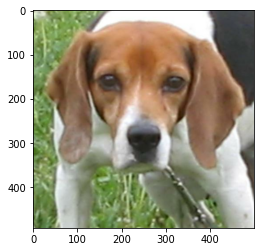

In [14]:
plt.imshow(example_image[0])

In [15]:
def format_image(image,label):
  image=tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image,label

BATCH_SIZE=32

train_batches=train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches=validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [16]:
image_batch,label_batch=next(iter(train_batches.take(1)))
image_batch=image_batch.numpy()
label_batch=label_batch.numpy()

result_batch=model.predict(image_batch)

predicted_class_names=imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['tiger cat', 'tabby', 'beagle', 'Egyptian cat', 'Weimaraner',
       'Egyptian cat', 'Egyptian cat', 'dingo', 'Persian cat',
       'Newfoundland', 'Egyptian cat', 'Egyptian cat', 'Walker hound',
       'redbone', 'Labrador retriever', 'Siamese cat', 'Egyptian cat',
       'English springer', 'dingo', 'toy terrier', 'tabby', 'Boston bull',
       'miniature pinscher', 'golden retriever', 'Egyptian cat',
       'Rhodesian ridgeback', 'papillon', 'toy terrier', 'tiger cat',
       'golden retriever', 'tabby', 'Egyptian cat'], dtype='<U30')

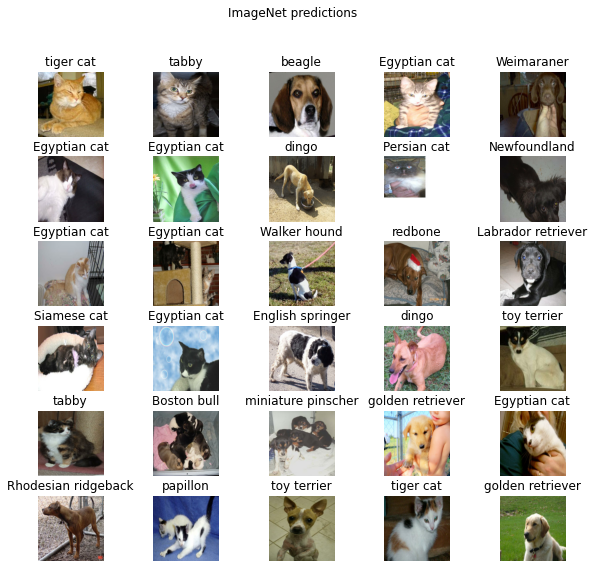

In [17]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# **`Transfer learning`**

In [26]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor=hub.KerasLayer(URL,input_shape=(IMAGE_RES,IMAGE_RES,3))

In [27]:
feature_extractor.trainable=False

In [28]:
model=tf.keras.Sequential([feature_extractor,
                          layers.Dense(2,activation='softmax')])

In [29]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [30]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [36]:
epochs=6

In [32]:
history=model.fit(train_batches,validation_data=validation_batches,epochs=6,batch_size=BATCH_SIZE)

Epoch 1/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0520 - accuracy: 0.9816 - val_loss: 0.0314 - val_accuracy: 0.9893
Epoch 2/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0294 - accuracy: 0.9903 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 3/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.0301 - val_accuracy: 0.9899
Epoch 4/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0227 - accuracy: 0.9920 - val_loss: 0.0339 - val_accuracy: 0.9882
Epoch 5/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 6/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0323 - val_accuracy: 0.9899


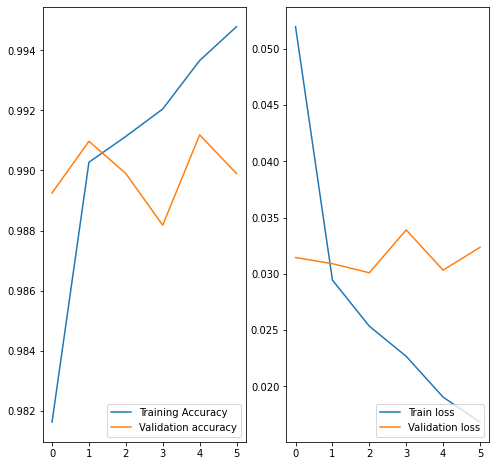

In [46]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epoch_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range,train_accuracy,label='Training Accuracy')
plt.plot(epoch_range,val_accuracy,label='Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epoch_range,loss,label='Train loss')
plt.plot(epoch_range,val_loss,label='Validation loss')
plt.legend(loc='lower right')

In [51]:
class_names=np.array(info.features['label'].names)

In [53]:
class_names

array(['cat', 'dog'], dtype='<U3')

In [54]:
predicted_batch=model.predict(image_batch)

In [58]:
predicted_batch=np.argmax(predicted_batch,axis=-1)

In [59]:
predicted_class_names=class_names[predicted_batch]

In [60]:
predicted_class_names

array(['cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat',
       'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog',
       'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

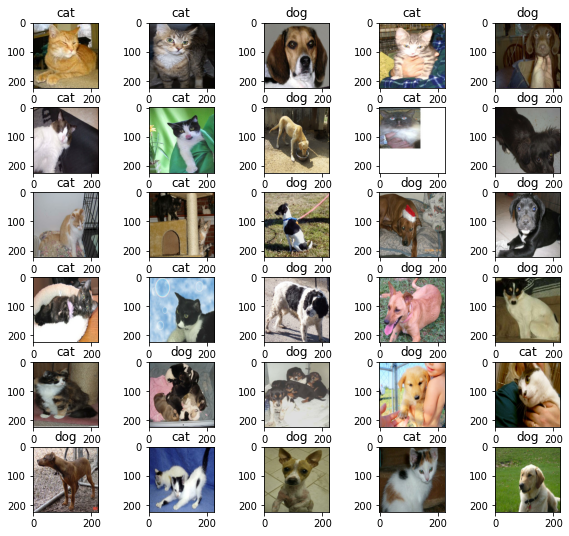

In [69]:
plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[i])
  plt.title(predicted_class_names[i])